In [1]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm
import math


# Update the rcParams to remove top and right spines by default
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = False
plt.rcParams['legend.frameon'] = False

In [2]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

def read_request(route_id, ymd, idx_file):
    """
    Gepaste docstring in het goede formaat.
    Als je dit in het goede formaat doet kan je meteen documentatie maken
    https://realpython.com/python-project-documentation-with-mkdocs/
    """
    
    folder_requests = os.path.join('..', 'data', 'input', 'requests', f"{route_id}-{ymd}")
    if not os.path.exists(folder_requests):
        return None

    file_request = os.listdir(folder_requests)[idx_file]
    file_path_request = os.path.join(folder_requests, file_request)


    with open(file_path_request, 'r') as f:
        request = json.load(f)

    rows = list()
    for task in request['tasks']:
        # TODO: Dit kan efficienter met een specifieke methode (pd.explode, json to dataframe zaken)
        if task['id'] == 'E1':
            continue ## TODO: Also retain this task!
        row = {'id' : int(task['id']),
                    'lat' : task['address']['latitude'],
                    'long' : task['address']['longitude'],
                    'start_time' : task['timeWindow']['from'],
                    'end_time' : task['timeWindow']['till']}
        rows.append(row)

    return pd.DataFrame(rows).sort_values(by = 'id')

def sort_request(df_request, route_id, ymd, idx_file):
    """
    Docstring!
    """
    folder_response = os.path.join('..', 'data', 'input', 'responses', f"{route_id}-{ymd}")
    file_response = os.listdir(folder_response)[idx_file]
    file_path_response = os.path.join(folder_response, file_response)

    with open(file_path_response, 'r') as f:
        content = f.read()
        if 'E1' in content: ## TODO: Deal with this better
            return None
        response = list(map(int, content.split('\n')))
    response.append(response[0])

    return (df_request.set_index('id')
                        .loc[response, :]
                        .reset_index())

def visualize_request(route_id, ymd, idx_file):
    """
    This is actually a graph, could be plotted with NetworkX
    """

    fig, ax = plt.subplots()
    df_request = read_request(route_id, ymd, idx_file)
    df_request = sort_request(df_request, route_id, ymd, idx_file)
    df_request.plot(x = 'lat', y = 'long', ax = ax, marker = '>', label = 'Route')

    df_request.iloc[[0], :].plot(x = 'lat', y = 'long', ax = ax, marker = 'o', color = 'r', ls = '', label = 'start')
    return fig, ax
    
def create_summary(loc_summary, threshold_time = 12):
    df_summary = pd.read_excel(loc_summary)
    df_summary = df_summary.rename({' Time' : 'Time'}, axis = 1)
    # Trim spaces and add leading zero to time
    df_summary['Time'] = (df_summary['Time'].str
                                            .strip()
                                            .apply(lambda time : ('0' 
                                                                    + time.split(':')[0])[-2:] 
                                                                    + ':' 
                                                                    + ':'.join(time.split(':')[1:]) ))

    df_summary['datetime'] = pd.to_datetime(df_summary['Date'] + df_summary['Time'], format='%m/%d/%Y%I:%M:%S.%f %p')
    df_summary = df_summary.drop(['Time'], axis=1)
    df_summary = df_summary.loc[df_summary.datetime.dt.hour <= threshold_time]
    df_summary = df_summary.sort_values(by = 'datetime')
    df_summary = df_summary.loc[df_summary.RouteId.str.startswith('0521_')]
    return df_summary

def create_diff_tasks(df_summary):
    rows = list()
    for (date, route_id), group in df_summary.groupby(['Date', 'RouteId']):
        diff_nr_tasks = group.iloc[-1].NumberOfTasks - group.iloc[0].NumberOfTasks
        rows.append({'date' : date,
                        'route_id' : route_id,
                        'diff_nr_tasks' : diff_nr_tasks})
    return pd.DataFrame(rows)

## Visualizeer specifieke routes

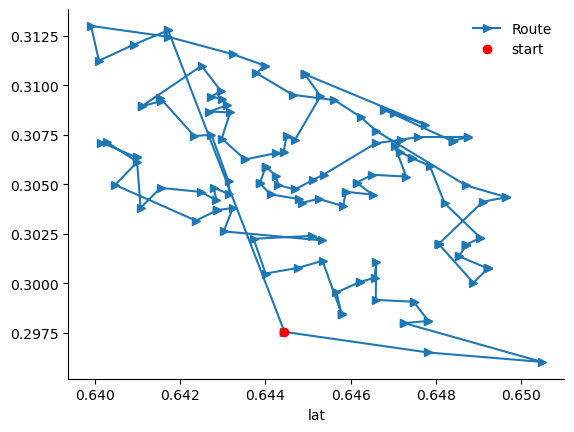

In [3]:
route_id = '0521_301'
ymd = '20220621'
idx_file = 0

fig, ax = visualize_request(route_id, ymd, idx_file)

## Verandering in aantal stops eerste vs laatste request

In [4]:
loc_summary = r'..\data\input\ModifiedQueryRows.xlsx'
df_summary = create_summary(loc_summary)
df_diff_tasks = create_diff_tasks(df_summary)

Avg nr of tasks added: -11.385039141780226
Median nr of tasks added: -2.0


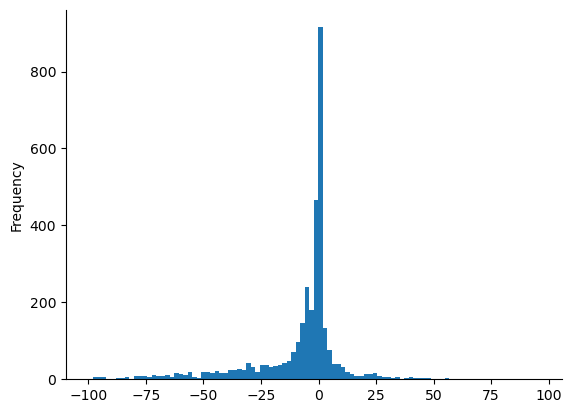

In [5]:
print(f"Avg nr of tasks added: {df_diff_tasks['diff_nr_tasks'].mean()}")
print(f"Median nr of tasks added: {df_diff_tasks['diff_nr_tasks'].median()}")
df_diff_tasks.query("-100 <= diff_nr_tasks <= 100")['diff_nr_tasks'].plot.hist(bins = 100);

## Outliers zoeken!

In [6]:
def get_route_tasks(df_summary, first_or_last = 'first'):

    dfs = list()
    idx_file = 0 if first_or_last == 'first' else -1
    for (date, route_id), _ in tqdm(list(df_summary.groupby(['Date', 'RouteId']))):
        ymd = pd.to_datetime(date, format = '%m/%d/%Y').strftime('%Y%m%d')
        df_request = read_request(route_id, ymd, idx_file)
        if df_request is None:
            continue
        # df_request = sort_request(df_request, route_id, ymd, idx_file) # To fix!
        df_request['date'] = date
        df_request['route_id'] = route_id
        df_request['first_or_last'] = first_or_last
        dfs.append(df_request)
    return pd.concat(dfs, ignore_index = True)

In [7]:
# TODO: Investigate mismatch between summary and files, for now skip those we do not find

df_requests_first = get_route_tasks(df_summary, first_or_last = 'first')
df_requests_last = get_route_tasks(df_summary, first_or_last = 'last')
df_requests = pd.concat([df_requests_first, df_requests_last], ignore_index = True)

  0%|          | 5/3449 [00:06<1:10:02,  1.22s/it]


KeyboardInterrupt: 

In [28]:
def detect_outliers_zscore(data):
    z_scores = stats.zscore(data)
    abs_z_scores = abs(z_scores)
    outlier_indices = (abs_z_scores > 3).any(axis=1)
    return data[outlier_indices]

    
# COuld be done with a .tranform
groups = list()
for (date, route_id), group in df_requests.groupby(['date', 'route_id']):
    group['is_outlier'] = False
    outliers = detect_outliers_zscore(group[['lat', 'long']])
    group.loc[outliers.index, 'is_outlier'] = True
    groups.append(group)

df_requests = pd.concat(groups)

<Axes: ylabel='Frequency'>

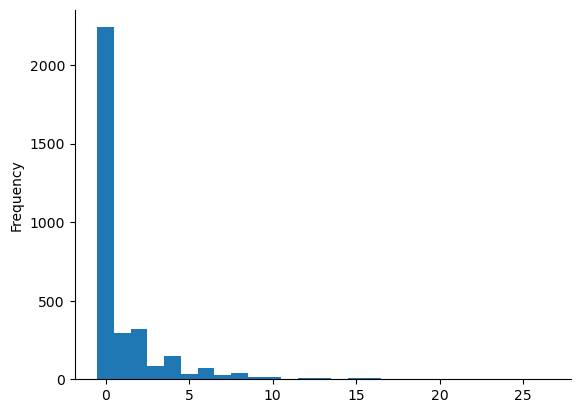

In [25]:
num_outliers = df_requests.groupby(['route_id', 'date'])['is_outlier'].sum()
bins = np.arange(num_outliers.values.min() - .5, num_outliers.values.max() + 1.5, 1)
num_outliers.plot.hist(bins = bins)

## Aantal punten per request

#### Deel 1: wat ligt vast, wat niet?

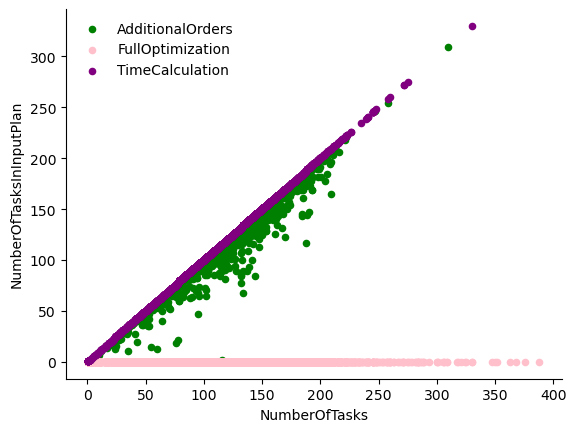

In [11]:
fig, ax = plt.subplots()

colors = {'FullOptimization' : 'pink',
            'AdditionalOrders' : 'green',
            'TimeCalculation' : 'purple'}

for triggertype, group in df_summary.groupby('TriggerType'):
    #if triggertype != 'AdditionalOrders':
    #    continue
    group.plot.scatter(x = 'NumberOfTasks', 
                                    y = 'NumberOfTasksInInputPlan', 
                                    ax = ax,
                                    label = triggertype,
                                    color = colors[triggertype])

Text(0.5, 0, 'Percentage additional orders')

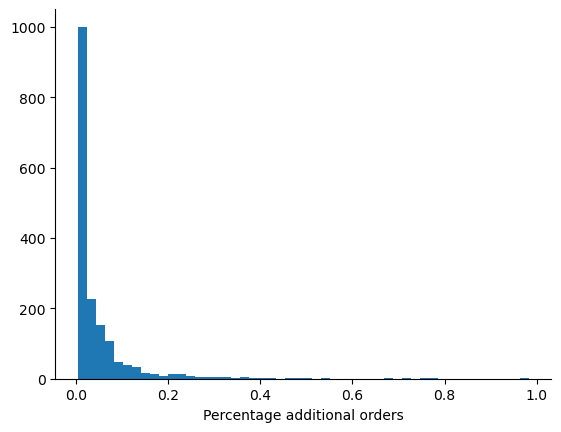

In [12]:
df_additional = df_summary.query("TriggerType == 'AdditionalOrders'")
plt.hist((df_additional.NumberOfTasks  - df_additional.NumberOfTasksInInputPlan) / df_additional.NumberOfTasks, bins = 50);
plt.xlabel("Percentage additional orders")

#### Deel 2: Verdeling van NumberOfTasks

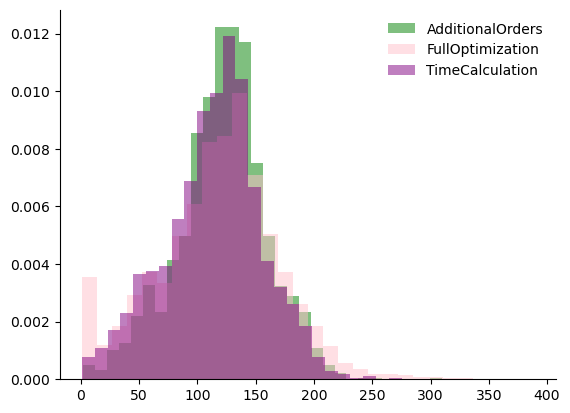

In [13]:
fig, ax = plt.subplots()

for triggertype, group in df_summary.groupby('TriggerType'):
    #if triggertype != 'AdditionalOrders':
    #    continue
    group.NumberOfTasks.hist(ax = ax,
                                    label = triggertype,
                                    color = colors[triggertype],
                                    alpha = 0.5,
                                    density = True,
                                    bins = 30)
    
ax.grid(False)
ax.legend(frameon = False)

### Zijsprongetje: komen punten meerdere keren voor?

<Axes: >

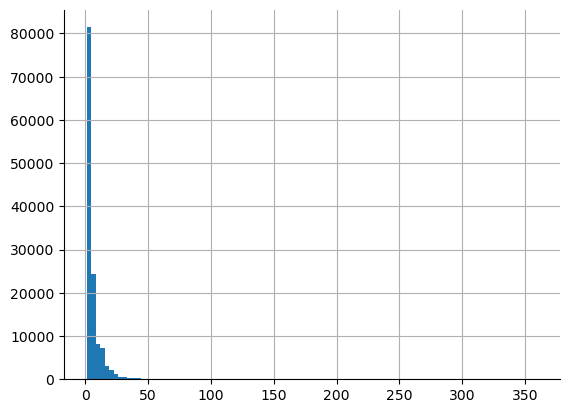

In [14]:
df_requests.groupby(['long', 'lat']).size().reset_index(name='count')['count'].hist(bins = 100)
# Bijna niet

## Inspectie op aantal km gereden

#### Deel 1: preprocessing

In [29]:
rows = list()
for (date, route_id, first_or_last), df_request in tqdm(df_requests.groupby(['date', 'route_id', 'first_or_last'])):
    for i in range(len( df_request )):
        first_point = df_request.iloc[i]
        second_point = df_request.iloc[(i + 1) % len(df_request)]
        dist = haversine_distance(first_point.lat, first_point.long, second_point.lat, second_point.long)
        rows.append({'dist' : dist,
                        'last_point' : i + 1 == len(df_request),
                        'id' : df_request.iloc[i].id,
                        'date' : date,
                        'route_id' : route_id,
                        'first_or_last' : first_or_last})

df_right = pd.DataFrame(rows)
for col in df_right.columns:
    if (col in df_requests.columns) and (col not in ['id', 'date', 'route_id']):
        df_requests = df_requests.drop(col, axis = 1)
df_requests = pd.merge(left = df_requests,
                                right = df_right,
                                on = ['id', 'date', 'route_id'])

### Afstand eerste & laatste punt vs afstanden algemeen

last_point
False    0.667087
True     1.618701
Name: dist, dtype: float64

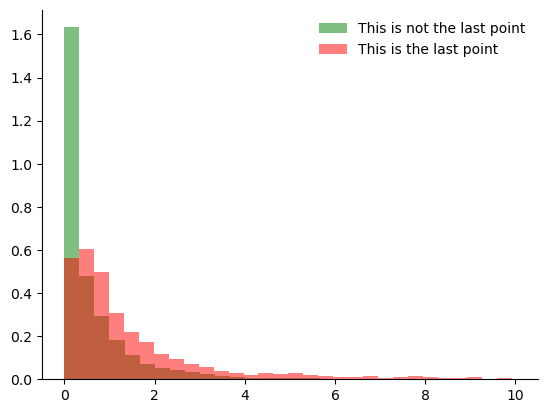

In [31]:
display(df_requests.groupby('last_point')['dist'].mean())

fig, ax = plt.subplots()
colors = ['g', 'r']
for last_point, group in df_requests.groupby('last_point'):
    group.query("dist <= 10").dist.hist(ax = ax,
                                            label = f"This is{' not' if not last_point else ''} the last point",
                                            color = colors[last_point],
                                            alpha = 0.5,
                                            density = True,
                                            bins = 30)
    
ax.grid(False)
ax.legend(frameon = False)

### First vs last route total km driven

In [32]:
df_summary.query("RouteId == '0521_301' and Date == '6/18/2022'")

,Date,OptimizationRequestId,RouteId,TriggerType,ConfigurationName,NumberOfTasks,NumberOfTasksInInputPlan,datetime
68140,6/18/2022,e7cc386f-ba73-41c4-a81c-8f33f2cf15d3,0521_301,FullOptimization,CreateSequence,49,0,2022-06-18 05:36:22.107
68154,6/18/2022,2f079c79-b428-4b34-a636-bb79cf20f4fa,0521_301,TimeCalculation,EstimateTime,49,49,2022-06-18 05:38:28.041
68340,6/18/2022,c26eef45-ebd7-4881-91c2-970bc744fc67,0521_301,TimeCalculation,EstimateTime,49,49,2022-06-18 05:51:42.636
68373,6/18/2022,76f55d04-a246-4a15-b5b5-4096bb768f05,0521_301,TimeCalculation,EstimateTime,49,49,2022-06-18 05:53:28.306


In [60]:
rows = list()
for (date, route_id), group in (df_requests.groupby(["route_id", "date", "first_or_last"])
                                                        ['dist']
                                                        .aggregate(['sum', 'count'])
                                                        .reset_index()
                                            .groupby(["route_id", "date"])):
    diff_distance = group.set_index('first_or_last').loc['last', 'sum'] - group.set_index('first_or_last').loc['first', 'sum']
    diff_count = group.set_index('first_or_last').loc['last', 'count'] - group.set_index('first_or_last').loc['first', 'count']
    rows.append({'diff_distance' : diff_distance,
                    'diff_count' : diff_count,
                    'date' : date,
                    'route_id' : route_id})

df_diff_distance = pd.DataFrame(rows)

<Axes: xlabel='diff_count', ylabel='diff_distance'>

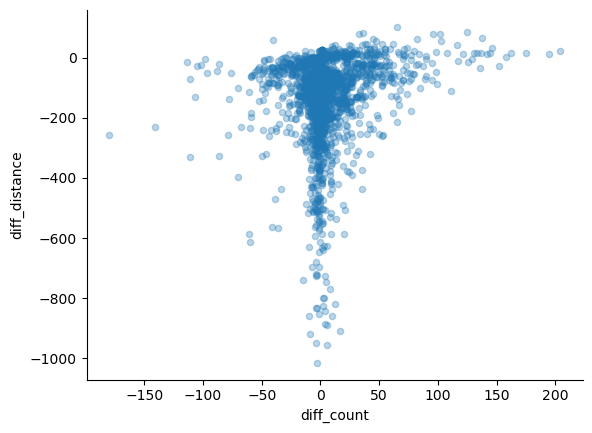

In [63]:
df_diff_distance.plot.scatter(x = 'diff_count', 
                                    y = 'diff_distance',
                                    alpha = 0.3)

<Axes: ylabel='Frequency'>

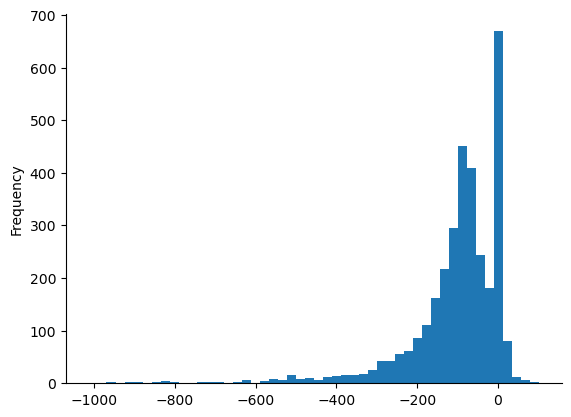

In [48]:
df_diff_distance.diff_distance.plot.hist(bins = 50)

### Kolom toevoegen "removed" toevoegen

In [77]:
df_requests_last

,id,lat,long,start_time,end_time,date,route_id,first_or_last
0,0,0.650488,0.296025,2022-05-30T07:30:00,2022-05-30T23:59:00,5/30/2022,0521_301,last
1,1,0.646361,0.297741,2022-05-30T07:30:00,2022-05-30T23:59:00,5/30/2022,0521_301,last
2,2,0.645787,0.298443,2022-05-30T07:30:00,2022-05-30T23:59:00,5/30/2022,0521_301,last
3,3,0.645787,0.298443,2022-05-30T07:30:00,2022-05-30T23:59:00,5/30/2022,0521_301,last
4,4,0.645666,0.299531,2022-05-30T07:30:00,2022-05-30T23:59:00,5/30/2022,0521_301,last
...,...,...,...,...,...,...,...,...
409568,59449,0.486119,0.297154,2022-06-09T07:30:00,2022-06-09T23:59:00,6/9/2022,0521_O69,last
409569,59450,0.486735,0.297264,2022-06-09T07:30:00,2022-06-09T23:59:00,6/9/2022,0521_O69,last
409570,59451,0.486847,0.296545,2022-06-09T07:30:00,2022-06-09T23:59:00,6/9/2022,0521_O69,last
409571,59452,0.487463,0.296873,2022-06-09T07:30:00,2022-06-09T23:59:00,6/9/2022,0521_O69,last


In [79]:
dict_group_last = {(date, route_id) : group_last for (date, route_id), group_last in df_requests_last.groupby(['date', 'route_id'])}

In [88]:
## TODO: FIX THIS!

dfs = list()
for (date, route_id), group_first in df_requests_first.groupby(['date', 'route_id']):
    group_last = dict_group_last[date, route_id]
    group_merged = pd.merge(left = group_first, #df_requests.query("first_or_last == 'first'"),
                                    right = group_last, # df_requests.query("first_or_last == 'last'"),
                                    on = ['id'],
                                    suffixes = ['', 'to_remove'],
                                    how = 'left')

    group_merged['is_removed'] = group_merged['first_or_lastto_remove'].isnull()
    group_merged = group_merged.drop([col for col in group_merged.columns if col.endswith('to_remove')], axis = 1)
    dfs.append(group_merged)

df_removed = pd.concat(dfs, ignore_index=  True)

In [91]:
df_removed.is_removed.mean()

0.8589521533366063

In [75]:
# TODO: Sanity check: ids for multiple requests on the same route are the same
# TODO: Extend methodology to also have the added ones

df_requests_removed = pd.merge(left = df_requests_first, #df_requests.query("first_or_last == 'first'"),
                                    right = df_requests_last, # df_requests.query("first_or_last == 'last'"),
                                    on = ['id', 'route_id', 'date'],
                                    suffixes = ['', 'to_remove'])

df_requests_removed['is_removed'] = df_requests_removed['first_or_lastto_remove'].isnull()
df_requests_removed = df_requests_removed.drop([col for col in df_requests_removed.columns if col.endswith('to_remove')], axis = 1)

In [76]:
df_requests_removed.is_removed.mean()

0.0